In [2]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve

# Model selection
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

# Feature selection
from sklearn.feature_selection import RFE

# Plotting
import altair as alt

In [3]:
X_train = pd.read_csv("../data/clean-data/Xtrain-clean-autism-screening.csv", index_col=0)
y_train = pd.read_csv("../data/clean-data/ytrain-clean-autism-screening.csv", index_col=0)
X_test = pd.read_csv("../data/clean-data/Xtest-clean-autism-screening.csv", index_col=0)
y_test = pd.read_csv("../data/clean-data/ytest-clean-autism-screening.csv", index_col=0)


# Make validation set 

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=414)

numeric_features = ["age", 
                    "result"]

one_hot_features = ["gender", 
                    "ethnicity", 
                    "jaundice", 
                    "country_of_res", 
                    "used_app_before", 
                    "age_desc", 
                    "relation",
                    "Class/ASD"]

other_columns = list(X_train.columns[0:10])

In [4]:
preprocessor = ColumnTransformer(sparse_threshold=0,
    transformers=[
        ("scale", 
         StandardScaler(), 
         numeric_features),
        ("one_hot", 
         OneHotEncoder(drop=None, 
                       handle_unknown="ignore"), 
         one_hot_features)
    ])

X_train_temp = pd.DataFrame(preprocessor.fit_transform(X_train), 
            index = X_train.index,
            columns = (numeric_features + 
                       list(preprocessor
                           .named_transformers_["one_hot"]
                           .get_feature_names(one_hot_features)))
                      )

X_test_temp = pd.DataFrame(preprocessor.transform(X_test),
                     index = X_test.index,
                     columns = X_train_temp.columns)

X_valid_temp = pd.DataFrame(preprocessor.transform(X_valid),
                     index = X_valid.index,
                     columns = X_train_temp.columns)

X_train = X_train_temp.join(X_train[other_columns])
X_test = X_test_temp.join(X_test[other_columns])
X_valid = X_valid_temp.join(X_valid[other_columns])

le = LabelEncoder()

y_train = le.fit_transform(y_train.to_numpy().ravel())
y_test = le.transform(y_test.to_numpy().ravel())
y_valid = le.transform(y_valid.to_numpy().ravel())

In [16]:
## Trying Gridsearch on different models to find best

## Initialize models
lr = LogisticRegression()
dt = DecisionTreeClassifier(random_state=414)
rf = RandomForestClassifier(random_state=414)
svm = SVC(random_state=414)
knn = KNeighborsClassifier()

# Make list for models and a list to store their values
estimators = [lr, dt, rf, svm, knn]
best_parameters = []
best_precision_scores = []

# Make list of dictionaries for parameters
params = [{'C':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'penalty': ['l1', 'l2']},
         {'max_depth': [1, 5, 10, 15, 20, 25, None],
         'max_features': [3, 5, 10, 20, 25, 50, 100, None]},
         {'min_impurity_decrease': [0, 0.25, 0.5],
         'max_features': [3, 5, 10, 20, 50, 100, 'auto']},
         {'C':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'gamma':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
         {'n_neighbors': [2, 5, 10, 15, 20, 50, 100],
         'algorithm': ['auto', 'brute']}]

# Run for loop to best parameters for each model
# Scoring = recall to reduce false positives
for i in range(len(estimators)):
    search = GridSearchCV(estimator=estimators[i], 
                          param_grid=params[i],
                          cv = 10,
                          n_jobs=-1,
                         scoring='recall')
    
    search_object = search.fit(X_train, y_train)
    
    # Store the output on each iteration
    best_parameters.append(search_object.best_params_)
    best_precision_scores.append(search_object.best_score_)

best_parameters[np.argmax(best_precision_scores)]

/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'max_depth': 20, 'max_features': 50}

In [98]:
# the best precision score comes from a decision tree classifier with max_depth=20 and max_features=50
# and recall = 0.46

dt = DecisionTreeClassifier(max_depth=20, max_features=50, random_state=414)
dt.fit(X_train, y_train).score(X_train, y_train)


# It gets almost perfect on the train set

dt.score(X_valid, y_valid)

# and ~82.6% on the validation set

prelim_matrix = pd.DataFrame(confusion_matrix(y_valid, dt.predict(X_valid)))


preliminary_matrix = prelim_matrix.rename(columns={0:"predicted negative", 1:'predicted positive'}, 
                  index={0:"predicted negative", 1:'predicted positive'}).swapaxes(0,1)

preliminary_matrix.to_csv('../data/preliminary_matrix.csv')

preliminary_matrix

,predicted negative,predicted positive
predicted negative,70,10
predicted positive,6,6


In [81]:
dt.score(X_valid, y_valid)

0.8260869565217391

In [82]:
## Subset just the questions:

questions = ['A1_Score',
       'A2_Score',
       'A3_Score',
       'A4_Score',
       'A5_Score',
       'A6_Score',
       'A7_Score',
       'A8_Score',
       'A9_Score',
       'A10_Score']

questions_train_df = X_train[questions]

questions_valid_df = X_valid[questions]

questions_test_df = X_test[questions]

In [83]:
# Attribution: Varada Kolhatkar

class ForwardSelection:
    def __init__(self, 
                 model, 
                 min_features=None, 
                 max_features=None, 
                 scoring=None, 
                 cv=None):
        """
        Initializes a model object that can then fit and transform train and test data
        """
        self.max_features = max_features
        if min_features is None:
            self.min_features = 1
        else:
            self.min_features = min_features

        self.model = model
        self.scoring = scoring
        self.cv = cv
        self.ftr_ = []
        return
    
    def fit(self, X, y):
        """
        Finds the features from X that best predict y
        """
        
        error = np.inf
        best = None
        feature_index = list(range(0, (X.shape[1])))
        errors = []
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=514)

        X_temp = X_train

        while error > 0.0:
            if best is not None:
                if best not in feature_index:
                    del feature_index[-2]
                    break
                feature_index.remove(best)

            for i in feature_index:
                self.model.fit(X_temp[:, self.ftr_ + [i]], y_train)
                temp_error = 1-np.mean(cross_val_score(self.model, X[:, self.ftr_ + [i]], y, scoring='f1'))

                if temp_error < error:
                    error = temp_error
                    best = i

            errors.append(round(error, 3))

            if len(errors) > 2:
                if errors[-1] >= errors[-2]:
                    break

            if self.max_features is not None:
                if len(errors) > self.max_features:
                    break

            self.ftr_.append(best)


    def transform(self, X, y=None):
        """
        Transforms the test set to have the best features selected from self.fit()        
        """
        return X[:, self.ftr_]
    

In [84]:
fs = ForwardSelection(DecisionTreeClassifier(), max_features=None)

# np.mean(cross_val_score(dt, questions_train_df, y_train, scoring='precision'))

fs.fit(questions_train_df.to_numpy(), y_train)

fs.ftr_

# No single one question is better than any other one question so forward selection won't work
# Or it just won't work with a decision tree

[0, 0]

In [85]:
# Find the best features using RFE
rfe=RFE(DecisionTreeClassifier(), n_features_to_select=5)

rfe.fit(questions_train_df, y_train)

# The top 5 questions:

top_five = np.where(rfe.ranking_ == 1)[0]

X_train_best_5 = questions_train_df.to_numpy()[:,top_five]
X_test_best_5 = questions_test_df.to_numpy()[:,top_five]
X_valid_best_5 = questions_valid_df.to_numpy()[:,top_five]

In [86]:
np.where(rfe.ranking_ == 1)[0]

array([3, 4, 5, 7, 9])

In [87]:
### Best questions 

# The top five questions are A4, A5, A6, A8, and A10

In [88]:
# Can't use max_features=50 as there are only 5 features
dt2 = DecisionTreeClassifier(max_depth=20, max_features=5, random_state=414)

dt2.fit(X_train_best_5, y_train)

pd.DataFrame(confusion_matrix(y_valid, dt2.predict(X_valid_best_5)))

# Using just the top 5 questions gets a much worse result than using all the features

,0,1
0,76,0
1,16,0


In [89]:
# Recall of 0 with top five questions
print(classification_report(y_valid, dt2.predict(X_valid_best_5)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90        76
           1       0.00      0.00      0.00        16

    accuracy                           0.83        92
   macro avg       0.41      0.50      0.45        92
weighted avg       0.68      0.83      0.75        92



/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
# Try all questions:
dt3 = DecisionTreeClassifier(max_depth=20, max_features=10, random_state=414)

dt3.fit(questions_train_df, y_train)

pd.DataFrame(confusion_matrix(y_valid, dt3.predict(questions_valid_df)))


,0,1
0,70,6
1,13,3


In [91]:
# Recall of 0.19 with all questions on validation set
print(classification_report(y_valid, dt3.predict(questions_valid_df)))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88        76
           1       0.33      0.19      0.24        16

    accuracy                           0.79        92
   macro avg       0.59      0.55      0.56        92
weighted avg       0.75      0.79      0.77        92



In [92]:
# Recall with 0.38 with all features on validation set
print(classification_report(y_valid, dt.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        76
           1       0.50      0.38      0.43        16

    accuracy                           0.83        92
   macro avg       0.69      0.65      0.66        92
weighted avg       0.81      0.83      0.82        92



In [93]:
# Recall of 0.07 with all features on test set
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       100
           1       0.07      0.07      0.07        15

    accuracy                           0.76       115
   macro avg       0.46      0.46      0.46       115
weighted avg       0.76      0.76      0.76       115



In [94]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, dt.predict(X_test)))

final_matrix = conf_matrix.rename(columns={0:"predicted negative", 1:'predicted positive'}, 
                  index={0:"actual negative", 1:'actual positive'}).swapaxes(0,1)

final_matrix.to_csv('../data/confusion_matrix.csv')

In [95]:
# ROC curve

fpr, tpr, _ = roc_curve(y_valid, dt.predict_proba(X_valid)[:,1])

roc_df = pd.DataFrame({"fpr":fpr, "tpr":tpr})

line_df = pd.DataFrame({"start":[0,1], "end":[0,1]})

roc = alt.Chart(roc_df).mark_line().encode(
    x = alt.X("fpr:Q"),
    y = alt.Y("tpr:Q")
)
    
line = alt.Chart(line_df).mark_line(strokeDash=[5,5], color="orange").encode(
    x = alt.X("start:Q", axis=alt.Axis(title="False Positive Rate")),
    y = alt.Y("end:Q", axis=alt.Axis(title="True Positive Rate"))
)
    
chart = (roc + line).configure_axis(titleFontSize=20).properties(title="ROC Curve").configure_title(fontSize=20)

chart

chart.save('../img/ROC.png', webdriver='firefox')

In [96]:
## Extra stuff

# Importance of each feature according to the model
dt.feature_importances_

array([0.24230255, 0.09187677, 0.00786028, 0.03161909, 0.        ,
       0.00683777, 0.        , 0.0215263 , 0.        , 0.0044447 ,
       0.00910464, 0.        , 0.01837712, 0.01519504, 0.01139628,
       0.00959848, 0.        , 0.        , 0.        , 0.02053229,
       0.        , 0.01840299, 0.01876383, 0.        , 0.02704742,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01823405, 0.        , 0.        , 0.0091616 ,
       0.        , 0.        , 0.01709442, 0.        , 0.        ,
       0.01709442, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01005035, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02855457, 0.        ,
       0.        , 0.01709442, 0.00956532, 0.08926987, 0.01519504,
       0.        , 0.00505584, 0.        , 0.        , 0.        ,
       0.00486859, 0.01696613, 0.        , 0.        , 0.01139

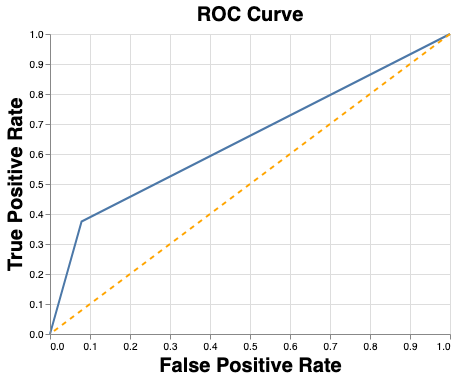

In [97]:
chart